In [1]:
from keras.applications import VGG16
from keras import backend as K

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet', include_top=False)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [4]:
grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

In [5]:
import numpy as np

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
loss_value

0.0

In [6]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step


In [15]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :,filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_image_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    
    for i in range(40):
        loss_value, grads_value = iterate([input_image_data])
        input_image_data += grads_value * step
    
    img = input_image_data[0]
    
    return deprocess_image(img)

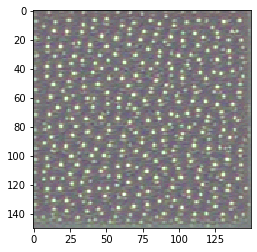

In [17]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


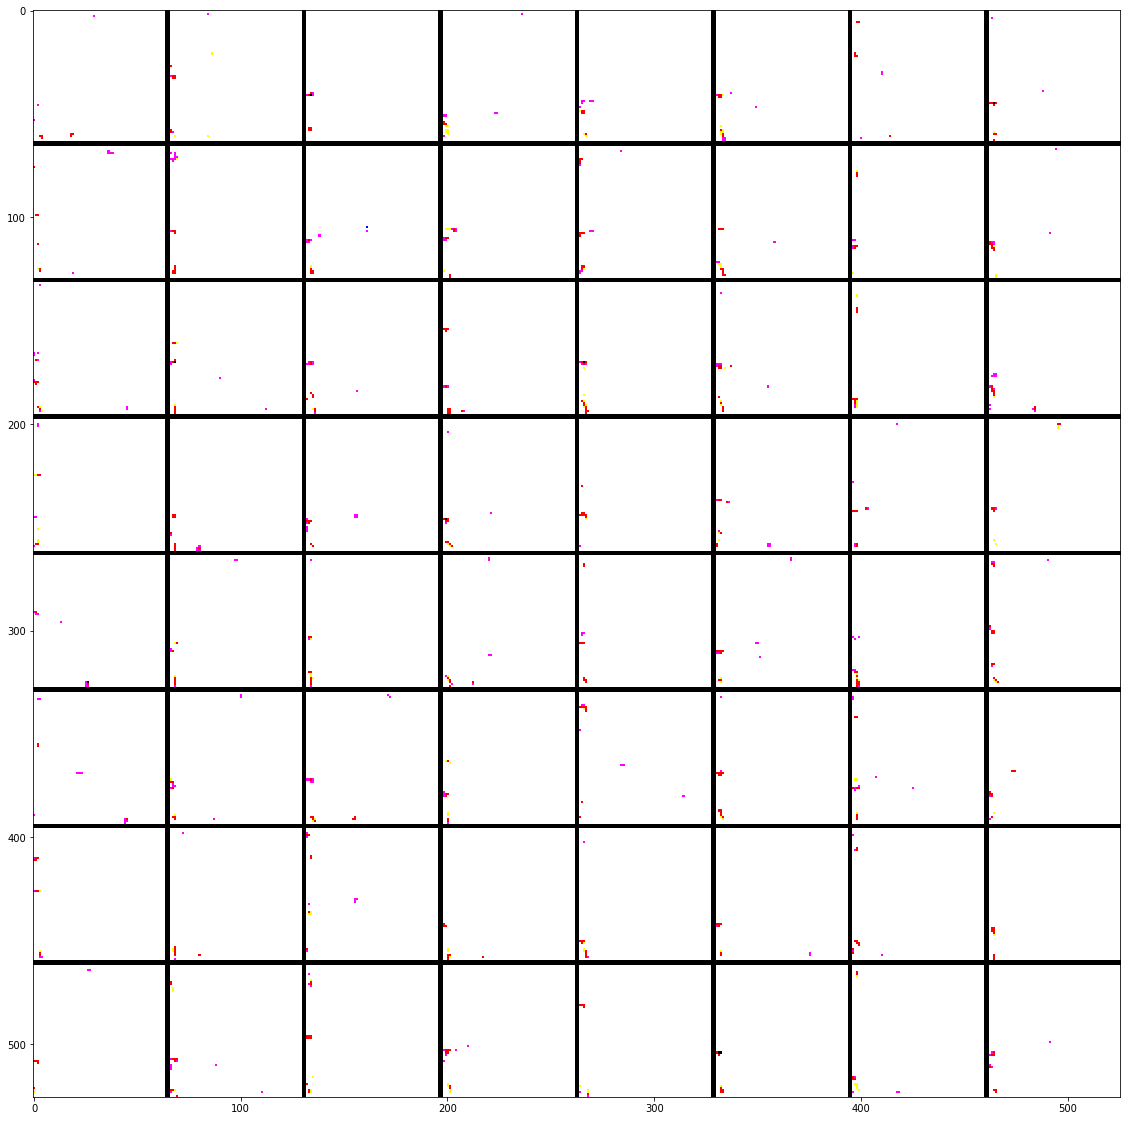

In [23]:
layer_name = 'block5_conv1'
size = 64
margin = 2
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

# 8x8网格
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, 0, size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.savefig('activation_{}.png'.format(layer_name))